In [1]:
import pandas as pd
import numpy as np
from glob import glob
from scipy import stats
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
import json
import random
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from transformer_lens import HookedTransformer
import torch
from jaxtyping import Float, Int
from collections import defaultdict
from sklearn.decomposition import TruncatedSVD
import itertools
import torch.nn.functional as F
import math
import seaborn as sns

## Setup

In [2]:
def get_device_str() -> str:
    if torch.backends.mps.is_available():
        return "mps"
    else:
        return "cuda" if torch.cuda.is_available() else "cpu"


def comp_js_divergence(
    p_logit: Float[torch.Tensor, "*batch vocab"],
    q_logit: Float[torch.Tensor, "*batch vocab"],
) -> Float[torch.Tensor, "*batch"]:
    p_logprob = torch.log_softmax(p_logit, dim=-1)
    q_logprob = torch.log_softmax(q_logit, dim=-1)
    p = p_logprob.exp()
    q = q_logprob.exp()

    # convert to log2
    p_logprob *= math.log2(math.e)
    q_logprob *= math.log2(math.e)

    m = 0.5 * (p + q)
    m_logprob = m.log2()

    p_kl_div = (p * (p_logprob - m_logprob)).sum(-1)
    q_kl_div = (q * (q_logprob - m_logprob)).sum(-1)

    assert p_kl_div.isfinite().all()
    assert q_kl_div.isfinite().all()
    return (p_kl_div + q_kl_div) / 2


def find_js_dist_blowup_max_slope(js_dists: List[float]):
    steps = list(range(len(js_dists)))

    slopes = []
    for i in range(1, len(steps)):
        dy = js_dists[i] - js_dists[i - 1]
        dx = steps[i] - steps[i - 1]
        slopes.append(dy / dx if dx != 0 else 0)

    # Pad the beginning of slopes list to match the length of steps
    slopes = [slopes[0]] + slopes
    return np.argsort(np.nan_to_num(slopes))[::-1][0]


def find_js_dist_blowup(
    js_dists: List[float],
    slope_threshold: float = 1.25,
    min_js_distance: float = 0.1,
    min_slope_threshold: float = 0.02,
) -> int:
    steps = list(range(len(js_dists)))

    slopes = []
    for i in range(1, len(steps)):
        dy = js_dists[i] - js_dists[i - 1]
        dx = steps[i] - steps[i - 1]
        slopes.append(dy / dx if dx != 0 else 0)

    # Pad the beginning of slopes list to match the length of steps
    slopes = [slopes[0]] + slopes

    for i in range(1, len(steps)):
        current_slope = slopes[i]
        prev_slope = slopes[i - 1]

        # print(f"step={i}, {current_slope=} {prev_slope=}, {slope_threshold * max(prev_slope, 1e-6)}")

        # Check if we're in an increasing trend and above minimum JS distance
        if (
            current_slope > (slope_threshold * max(prev_slope, 1e-6))
            or current_slope >= min_slope_threshold
        ) and js_dists[i] >= min_js_distance:
            return i

    return len(steps) - 1


def find_plateau_length_js(
    js_dists: List[float], threshold: float = 5e-03, window_size: int = 5
) -> int:

    def calculate_slope(y_values, x_values):
        slope, _, _, _, _ = stats.linregress(x_values, y_values)
        return slope

    for i in range(len(js_dists) - window_size + 1):
        window = js_dists[i : i + window_size]
        x_values = list(range(window_size))
        slope = calculate_slope(window, x_values)

        if abs(slope) > threshold:
            return i

    return len(js_dists) - 1


def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            # Parse each line as a JSON object
            json_object = json.loads(line.strip())
            data.append(json_object)
    return data


def get_feature_dir(sae, feature_id, feature_act, norm=False):
    feature_acts = torch.zeros(sae.W_enc.shape[1])

    # Activate the specified feature
    feature_acts[:] = 0
    feature_acts[feature_id] = feature_act

    # Decode back to the residual stream space
    perturbed_act = sae.decode(feature_acts)

    if norm:
        perturbed_act /= torch.norm(perturbed_act)

    return perturbed_act

In [3]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [4]:
perturbation_layer = "blocks.0.hook_resid_pre"
saes, sparsities = get_gpt2_res_jb_saes(perturbation_layer)
sae = saes[perturbation_layer].cpu()
feature_sparsities = 10 ** sparsities[perturbation_layer].cpu()

sae.eval()

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

## Load & Clean data

In [5]:
metadata, activations = [], []

for path in glob("observations/metadata*"):
    metadata.extend(load_jsonl(path))

for path in glob("observations/acts*"):
    activations.append(np.load(path))

activations = np.concatenate(activations)

In [6]:
len(metadata), activations.shape

(25000, (25000, 100, 768))

In [ ]:
# Clean data
clean_metadata = []
clean_activations = []

n_examples = 5000
idxs = random.sample(range(len(metadata)), n_examples)

max_recon_error = 3.0  # throws away roughly bottom 20%
c = 0

for idx in idxs:
    m = metadata[idx]
    acts = activations[idx]
    js_dists = [s["js_dist"] for s in m["steps_metadata"]]
    if np.isnan(js_dists).sum() > 1:
        continue

    act_recon = sae.decode(sae.encode(torch.tensor(acts[0])))
    recon_error = torch.tensor(acts[0]) - act_recon
    recon_error = recon_error.abs().sum(dim=-1).detach().numpy()

    if recon_error > max_recon_error:
        continue

    clean_metadata.append(m)
    clean_activations.append(acts)

    c += 1

    if c % 500 == 0:
        print(c)

clean_activations = np.stack(clean_activations)

In [9]:
len(clean_metadata), clean_activations.shape

(3479, (3479, 100, 768))

In [10]:
metadata = clean_metadata
activations = clean_activations

## Feature Dynamics

In [75]:
feature_activations = []
js_dists = []

example_idx = 0

for i, s in enumerate(metadata[example_idx]["steps_metadata"]):
    active_feature_ids = s["active_feature_ids"]
    active_feature_acts = s["active_feature_acts"]
    feature_acts = torch.zeros(sae.W_enc.shape[1])
    feature_acts[active_feature_ids] = torch.tensor(active_feature_acts)
    feature_activations.append(feature_acts)
    js_dists.append(s["js_dist"])

feature_activations = torch.stack(feature_activations)

### Gradients and acceleration

In [46]:
row_indices = np.arange(feature_activations.shape[0])[:, np.newaxis]
top_features_per_step = np.argsort(feature_activations)[:, -5:]
top_features_acts = feature_activations[row_indices, top_features_per_step]

gradients = np.gradient(top_features_acts, axis=0)
accelerations = np.gradient(gradients, axis=0)

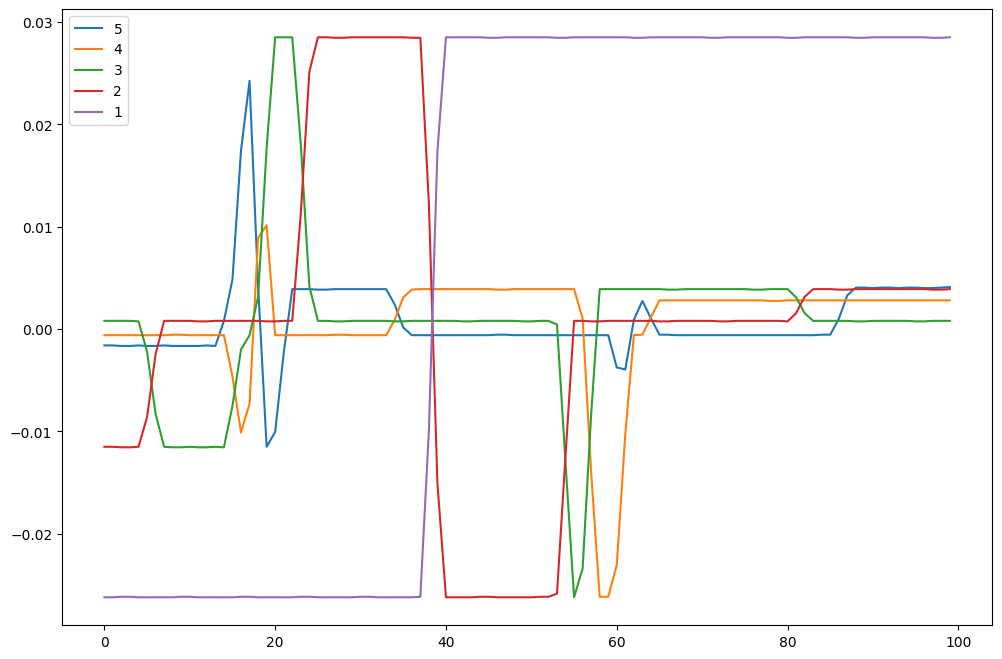

In [47]:
plt.figure(figsize=(12, 8))

for feature_idx in range(5):
    plt.plot(gradients[:, feature_idx], label=5 - feature_idx)

plt.legend()
plt.show()

### Heatmap of feature activations

In [116]:
def plot_heatmap_feature_acts(feature_activations, js_dists):
    # Assuming feature_activations is a PyTorch tensor
    feature_acts_np = (
        feature_activations.numpy()
    )  # Convert to numpy if it's not already

    # Identify top features from start and end
    n_top = 10
    start_top_features = np.argsort(feature_acts_np[0])[-n_top:][::-1]
    end_top_features = np.argsort(feature_acts_np[-1])[-n_top:][::-1]

    # Assume js_blowup_step is the time step where JS distance starts increasing rapidly
    js_blowup_step = find_js_dist_blowup(js_dists)  # Replace with your actual step

    # Combine and get unique features
    combined_features = np.unique(
        np.concatenate([start_top_features, end_top_features])
    )

    # Create labels for y-axis
    y_labels = []

    feature_ranks = []

    for feat in combined_features:
        start_rank = np.where(start_top_features == feat)[0]
        end_rank = np.where(end_top_features == feat)[0]
        feature_rank = 0

        label = f"F{feat}"
        if len(start_rank) > 0:
            label += f" (S-{start_rank[0]+1})"
            feature_rank += start_rank[0]
        else:
            feature_rank += n_top

        if len(end_rank) > 0:
            label += f" (E-{end_rank[0]+1})"
            if len(start_rank) == 0:
                feature_rank += 10 + end_rank[0]

        y_labels.append(label)
        feature_ranks.append(feature_rank)

    sorted_feature_ranks = np.argsort(feature_ranks)
    sorted_y_labels = [y_labels[idx] for idx in sorted_feature_ranks]

    # Create heatmap
    fig, ax = plt.subplots(figsize=(20, len(combined_features) / 2 + 2))
    sns.heatmap(
        feature_acts_np[:, combined_features[sorted_feature_ranks]].T,
        cmap="coolwarm",
        cbar_kws={"label": "Activation"},
        yticklabels=sorted_y_labels,
        ax=ax,
    )

    # Add vertical line for JS distance blowup
    ax.axvline(x=js_blowup_step, color="white", linestyle="--", linewidth=2)

    # Add text annotation for the JS blowup line
    ax.text(
        js_blowup_step,
        len(combined_features) - 0.25,
        "JS Dist Blowup",
        rotation=90,
        va="bottom",
        ha="right",
        color="white",
        fontweight="normal",
    )

    # Assuming js_distances is your array of JS distances over time
    ax2 = ax.twinx()
    ax2.plot(js_dists, color="white", linewidth=2)
    ax2.set_ylabel("JS Distance", color="white")
    ax2.tick_params(axis="y", labelcolor="white")

    plt.title("Top Feature Activations Over Time (Start and End)")
    plt.xlabel("Time Steps")
    plt.ylabel("Feature ID (Start Rank, End Rank)")
    plt.tight_layout()
    plt.show()

### Entropy analysis of feature activations

In [78]:
from scipy.stats import entropy

In [79]:
sae_recon_errors = []

for i, fa in enumerate(feature_activations):
    act = torch.tensor(activations[example_idx][i])
    act_recon = sae.decode(sae.encode(act))
    recon_error = (act - act_recon).abs().sum()
    sae_recon_errors.append(recon_error.item())

In [80]:
js_blowup_step = find_js_dist_blowup(js_dists)

In [94]:
js_plateau_len = find_plateau_length_js(js_dists)

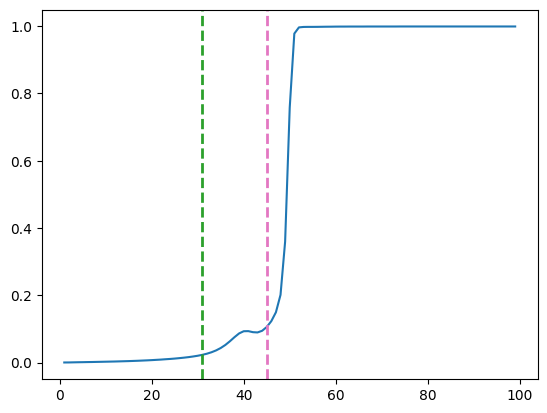

In [96]:
plt.plot(js_dists)
plt.axvline(x=js_plateau_len, color="tab:green", linestyle="--", linewidth=2)
plt.axvline(x=js_blowup_step, color="tab:pink", linestyle="--", linewidth=2)

In [59]:
feature_acts_distr = F.softmax(feature_activations, dim=-1)
entropies = [entropy(f, base=2) for f in feature_acts_distr]

In [60]:
corr, p_value = stats.spearmanr(entropies, sae_recon_errors)
print(corr, p_value)

0.5837623762376236 1.8343523450261075e-10


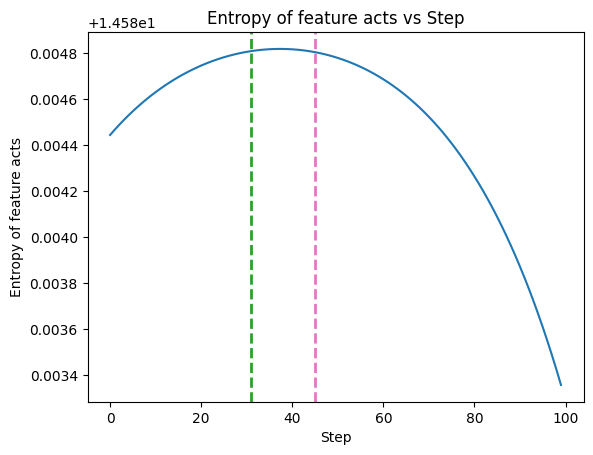

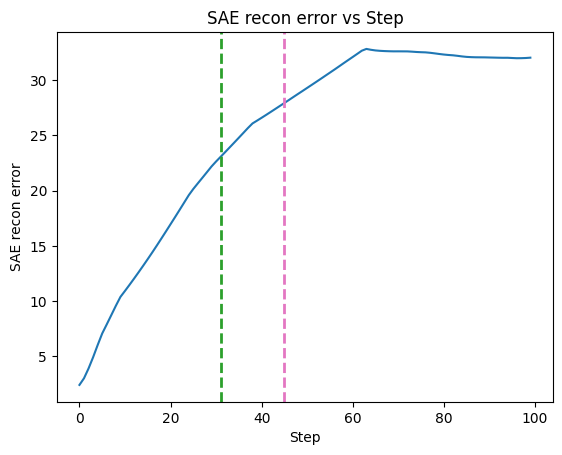

In [98]:
plt.plot(entropies)
plt.title("Entropy of feature acts vs Step")
plt.xlabel("Step")
plt.ylabel("Entropy of feature acts")
plt.axvline(x=js_plateau_len, color="tab:green", linestyle="--", linewidth=2)
plt.axvline(x=js_blowup_step, color="tab:pink", linestyle="--", linewidth=2)
plt.show()


plt.plot(sae_recon_errors)
plt.title("SAE recon error vs Step")
plt.xlabel("Step")
plt.ylabel("SAE recon error")
plt.axvline(x=js_plateau_len, color="tab:green", linestyle="--", linewidth=2)
plt.axvline(x=js_blowup_step, color="tab:pink", linestyle="--", linewidth=2)
plt.show()

### SAE reconstruction error correlation with blowup/plateau

In [174]:
js_dists = []
js_blowups = []
js_plateaus = []
sae_recon_errors = []
max_sae_recon_errors = []

for i, (m, acts) in enumerate(zip(metadata[:100], activations[:100])):
    act_recon = sae.decode(sae.encode(torch.tensor(acts)))
    recon_error = torch.tensor(acts) - act_recon
    sae_recon_errors.append(recon_error.abs().sum(dim=-1).detach().numpy())

    max_sae_recon_errors.append(recon_error.abs().sum(dim=-1).max(dim=-1)[1].item())
    m_js_dists = [
        0 if pd.isna(s["js_dist"]) else s["js_dist"] for s in m["steps_metadata"]
    ]
    js_dists.append(m_js_dists)
    js_blowup_step = find_js_dist_blowup(m_js_dists)
    js_plateau_len = find_plateau_length_js(m_js_dists)
    js_blowups.append(js_blowup_step)
    js_plateaus.append(js_plateau_len)

    if i % 50 == 0:
        print(i)

0


50


In [167]:
js_dists_flat = [v for j in js_dists for v in j]
sae_recon_errors_flat = [v for j in sae_recon_errors for v in j]

In [163]:
corr, p_value = stats.spearmanr(sae_recon_errors_flat, js_dists_flat)
print(f"Corr={corr:.4f}\nP-Value: {p_value:.4f}")

Corr=0.1405
P-Value: 0.0000


In [178]:
corr, p_value = stats.spearmanr(max_sae_recon_errors, js_blowups)
print(f"Corr={corr:.4f}\nP-Value: {p_value:.4f}")

Corr=0.1340
P-Value: 0.1839


## Feature Engineering

In [55]:
def get_feature_activations(steps):
    feature_activations = []
    for _, s in enumerate(steps):
        active_feature_ids = s["active_feature_ids"]
        active_feature_acts = s["active_feature_acts"]
        feature_acts = torch.zeros(sae.W_enc.shape[1])
        feature_acts[active_feature_ids] = torch.tensor(active_feature_acts)
        feature_activations.append(feature_acts)
    return torch.stack(feature_activations)


def find_crossover_point(feature_acts):
    start_feature = feature_acts[:, 0]
    end_feature = feature_acts[:, 1]

    # Compare absolute values
    mask = torch.abs(end_feature) > torch.abs(start_feature)

    # Find the first True value in the mask
    crossover_indices = torch.nonzero(mask)

    if crossover_indices.numel() > 0:
        return crossover_indices[0].item()
    else:
        return 0


def extract_crossover_features():
    pass

In [101]:
js_dists = []
js_blowups = []
crossover_points = []

for i, (m, acts) in enumerate(zip(metadata[:100], activations[:100])):
    steps = m["steps_metadata"]
    m_js_dists = [0 if pd.isna(s["js_dist"]) else s["js_dist"] for s in steps]
    js_dists.append(m_js_dists)
    js_blowup_step = find_js_dist_blowup(m_js_dists)
    js_blowups.append(js_blowup_step)

    feature_acts = get_feature_activations(steps)
    top_features_start = torch.argsort(feature_acts[0])[-5:].flip(dims=(0,))
    top_features_start_acts = feature_acts[0, top_features_start]

    top_features_end = torch.argsort(feature_acts[-1])[-5:].flip(dims=(0,))
    top_features_end_acts_at_start = feature_acts[0, top_features_end]

    feature_ids = [top_features_start[0].item(), top_features_end[0].item()]

    crossover_point = find_crossover_point(feature_acts[:, feature_ids])
    crossover_points.append(crossover_point)

    if i % 1000 == 0:
        print(i)

0


In [48]:
# # Quick test to see where the cross over point is and where the blowup happens
# idx = 1149

# steps = metadata[idx]['steps_metadata']
# m_js_dists = [0 if pd.isna(s["js_dist"]) else s["js_dist"] for s in steps]
# m_js_blowup_step = find_js_dist_blowup_max_slope(m_js_dists)

# plt.plot(m_js_dists)
# plt.yticks(np.arange(0, 1, 0.1))
# plt.axvline(x=m_js_blowup_step, color="tab:green", linestyle="--", linewidth=2)
# # plt.axvline(x=crossover_points[idx], color="tab:pink", linestyle="--", linewidth=2)


# # plot_heatmap_feature_acts(feature_acts, m_js_dists)

In [77]:
corr, p_value = stats.pearsonr(crossover_points, js_blowups)
print(f"Corr={corr:.4f}\nP-Value: {p_value:.4f}")

Corr=-0.3489
P-Value: 0.0000


## Prediction function

In [19]:
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import entropy

In [23]:
def find_crossover_point(feature_acts):
    start_feature = feature_acts[:, 0]
    end_feature = feature_acts[:, 1]

    # Compare absolute values
    mask = torch.abs(end_feature) > torch.abs(start_feature)

    # Find the first True value in the mask
    crossover_indices = torch.nonzero(mask)

    if crossover_indices.numel() > 0:
        return crossover_indices[0].item()
    else:
        return feature_acts.shape[0] // 2


def extract_crossover_point(feature_acts):
    top_features_start = torch.argsort(feature_acts[0])[-5:].flip(dims=(0,))
    top_features_end = torch.argsort(feature_acts[-1])[-5:].flip(dims=(0,))
    feature_ids = [top_features_start[0].item(), top_features_end[0].item()]
    crossover_point = find_crossover_point(feature_acts[:, feature_ids])
    return crossover_point


def get_data_for_step(steps):
    step_js_dists = [s["js_dist"] for s in steps]
    js_blowup_step = find_js_dist_blowup_max_slope(step_js_dists)
    sensitivity = 1 - js_blowup_step / len(step_js_dists)
    feature_acts = get_feature_activations(steps)
    return feature_acts, step_js_dists, js_blowup_step, sensitivity


def get_feature_activations(steps):
    feature_activations = []
    for _, s in enumerate(steps):
        active_feature_ids = s["active_feature_ids"]
        active_feature_acts = s["active_feature_acts"]
        feature_acts = torch.zeros(sae.W_enc.shape[1])
        feature_acts[active_feature_ids] = torch.tensor(active_feature_acts)
        feature_activations.append(feature_acts)
    return torch.stack(feature_activations)

In [25]:
labels = []
preds = []
max_acts = []

n_examples = min(1500, len(metadata))
idxs = random.sample(range(len(metadata)), n_examples)
# idxs = range(n_examples)

for i, idx in enumerate(idxs):
    steps = metadata[idx]["steps_metadata"]
    feature_acts, step_js_dists, js_blowup_step, sensitivity = get_data_for_step(steps)
    labels.append(sensitivity)

    max_acts.append(feature_acts[js_blowup_step].max().item())

    # row_indices = np.arange(feature_acts.shape[0])[:, np.newaxis]
    # top_features_per_step = np.argsort(feature_acts)[:, -3:].flip(dims=(1,))
    # top_features_acts = feature_acts[row_indices, top_features_per_step]

    # # Find crossover point
    # cp_point = extract_crossover_point(feature_acts)
    # pred_sensitivity_cp = 1 - cp_point / len(steps)

    # # Find max acceleration
    # row_indices = np.arange(feature_acts.shape[0])[:, np.newaxis]
    # top_features_per_step = np.argsort(feature_acts)[:, -5:]
    # top_features_acts = feature_acts[row_indices, top_features_per_step]

    # gradients = np.gradient(top_features_acts, axis=0)
    # accelerations = np.gradient(gradients, axis=0)

    # max_gradient = np.max(np.abs(accelerations), axis=1)
    # pred_step = np.argsort(max_gradient)[::-1][0]
    # pred_sensitivity_acc = 1 - pred_step / len(steps)

    # pred_sensitivity = np.mean([pred_sensitivity_cp, pred_sensitivity_acc])

    # print(f"{pred_sensitivity_cp=}, {pred_sensitivity_acc=}, {pred_sensitivity=}, {sensitivity=}")

    # preds.append(pred_sensitivity)

### Finding bad predictions

In [534]:
feature_activations[60].max()

tensor(1.3124)

In [463]:
diff = np.array(preds) - np.array(labels)
max_diff_idxs = np.argsort(-diff)[:10]

In [532]:
max_acts, _ = feature_acts.max(dim=-1)
np.argmax(max_acts > 2.0)

tensor(59)

0.37 63


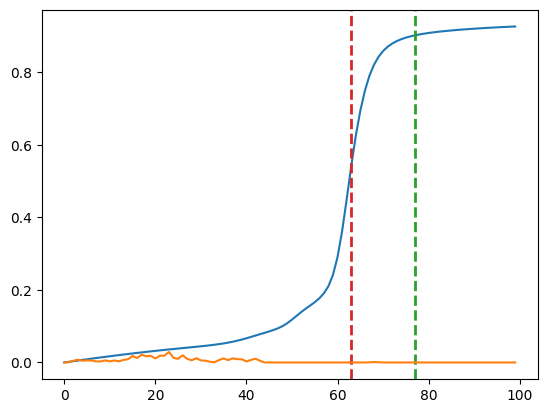

In [514]:
idx = max_diff_idxs[0]
steps = metadata[idx]["steps_metadata"]
feature_acts, step_js_dists, js_blowup_step, sensitivity = get_data_for_step(steps)

plt.plot(step_js_dists)
plt.axvline(x=js_blowup_step, color="tab:red", linestyle="--", linewidth=2)
plt.axvline(x=preds[idx] * 100, color="tab:green", linestyle="--", linewidth=2)

print(sensitivity, js_blowup_step)

row_indices = np.arange(feature_acts.shape[0])[:, np.newaxis]
top_features_per_step = np.argsort(feature_acts)[:, -10:]
top_features_acts = feature_acts[row_indices, top_features_per_step]

gradients = np.gradient(top_features_acts, axis=0)
accelerations = np.gradient(gradients, axis=0)

max_acc = np.max(np.abs(accelerations), axis=1)
plt.plot(max_acc)
plt.show()

# plot_heatmap_feature_acts(feature_activations, js_dists)

In [512]:
# sns.heatmap(accelerations, cmap='coolwarm')

### Evaluation

In [553]:
corr, p_value = stats.spearmanr(labels, preds)
print(f"Corr={corr:.4f}\nP-Value: {p_value:.4f}")

Corr=-0.2416
P-Value: 0.0000


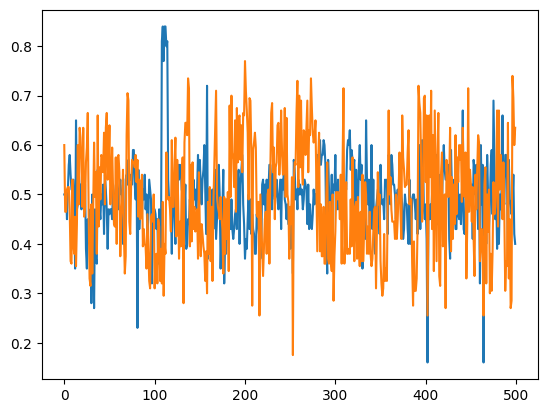

In [554]:
plt.plot(labels)
plt.plot(preds)

In [539]:
# Predict results
mse = mean_squared_error(labels, preds)
r2 = r2_score(labels, preds)

print(f"MSE: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

MSE: 0.5306
R-squared: -2.5805


## Modelling

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from scipy.stats import entropy
import cupy as cp

In [104]:
def get_feature_activations(steps):
    feature_activations = []
    for i, s in enumerate(steps):
        active_feature_ids = s["active_feature_ids"]
        active_feature_acts = s["active_feature_acts"]
        feature_acts = torch.zeros(sae.W_enc.shape[1])
        feature_acts[active_feature_ids] = torch.tensor(active_feature_acts)
        feature_activations.append(feature_acts)
    return torch.stack(feature_activations)


def find_crossover_point(feature_acts):
    start_feature = feature_acts[:, 0]
    end_feature = feature_acts[:, 1]

    # Compare absolute values
    mask = torch.abs(end_feature) > torch.abs(start_feature)

    # Find the first True value in the mask
    crossover_indices = torch.nonzero(mask)

    if crossover_indices.numel() > 0:
        return crossover_indices[0].item()
    else:
        return 0


def extract_crossover_point(feature_acts):
    top_features_start = torch.argsort(feature_acts[0])[-5:].flip(dims=(0,))
    top_features_end = torch.argsort(feature_acts[-1])[-5:].flip(dims=(0,))
    feature_ids = [top_features_start[0].item(), top_features_end[0].item()]
    crossover_point = find_crossover_point(feature_acts[:, feature_ids])
    return crossover_point


def compute_stats_in_buckets(data, n_buckets=5, split_point=None):
    # Calculate the size of each bucket
    if split_point is None:
        bucket_sizes = [data.shape[0] // n_buckets] * n_buckets
    else:
        bucket_sizes = [split_point, data.shape[0] - split_point]

    # Initialize arrays to store the computed statistics
    means = []
    stds = []
    medians = []
    max_vals = []
    min_vals = []

    # Compute statistics for each bucket
    for i in range(n_buckets):
        start_idx = i * bucket_sizes[i]
        end_idx = (i + 1) * bucket_sizes[i] if i < n_buckets - 1 else data.shape[0]

        bucket_data = data[start_idx:end_idx, :]

        means.extend(np.mean(bucket_data, axis=0))
        means.extend(np.std(bucket_data, axis=0))
        medians.extend(np.median(bucket_data, axis=0))
        max_vals.extend(np.max(bucket_data, axis=0))
        min_vals.extend(np.min(bucket_data, axis=0))

    # Combine all features
    features = np.concatenate([means, stds, medians, max_vals, min_vals])
    return features

In [112]:
feature_names = []

grad_feat_names = [
    f"grad_{fname}_top_{t}_bucket_{b}"
    for fname in ["mean", "std", "median", "max", "min"]
    for b in range(1, 3)
    for t in range(1, 4)
]
feature_names.extend(grad_feat_names)

# acc_feat_names = [
#     f"acc_{fname}_top_{t}_bucket_{b}"
#     for fname in ["mean", "std", "median", "max", "min"]
#     for b in range(1, 4)
#     for t in range(1, 4)
# ]
# feature_names.extend(acc_feat_names)

norm_feat_names = [
    f"norm_{fname}_bucket_{b}"
    for fname in ["mean", "std", "median", "max", "min"]
    for b in range(1, 3)
]
feature_names.extend(norm_feat_names)
feature_names.append("crossover_point_sens")

In [113]:
len(feature_names)

41

In [114]:
features = []
labels = []

n_examples = 1000
idxs = random.sample(range(len(metadata)), n_examples)

all_feature_acts = []

for i, idx in enumerate(idxs):
    steps = metadata[idx]["steps_metadata"]
    step_js_dists = [s["js_dist"] for s in steps]
    js_blowup_step = find_js_dist_blowup(step_js_dists)
    sensitivity = 1 - js_blowup_step / len(step_js_dists)
    labels.append(sensitivity)

    feature_activations = get_feature_activations(steps)

    cp_point = extract_crossover_point(feature_activations)
    cp_point_sens = 1 - cp_point / len(steps)

    if cp_point == 0 or cp_point == len(steps) - 1:
        cp_point = 50

    row_indices = np.arange(feature_activations.shape[0])[:, np.newaxis]
    top_features_per_step = np.argsort(feature_activations)[:, -3:].flip(dims=(1,))
    top_features_acts = feature_activations[row_indices, top_features_per_step]

    gradients = np.gradient(top_features_acts, axis=0)
    grad_feats = compute_stats_in_buckets(gradients, n_buckets=2, split_point=cp_point)

    # accelerations = np.gradient(gradients, axis=0)
    # acc_feats = compute_stats_in_buckets(accelerations, n_buckets=3)

    norms = (
        torch.norm(feature_activations - feature_activations[0], dim=-1)
        .unsqueeze(dim=1)
        .numpy()
    )
    norm_feats = compute_stats_in_buckets(norms, n_buckets=2, split_point=cp_point)

    pert_feats = np.concatenate([grad_feats, norm_feats, [cp_point_sens]])
    # pert_feats = np.concatenate([grad_feats, acc_feats])
    features.append(pert_feats)
    all_feature_acts.append(feature_activations)

    if i % 500 == 0:
        print(f"Step {i}")

all_feature_acts = torch.stack(all_feature_acts)

Step 0
Step 500


In [116]:
# pd.DataFrame(features, columns=feature_names)

In [117]:
X = np.vstack(features)
y = np.array(labels)
print(X.shape, len(y))

(1000, 41) 1000


### Learning Curve

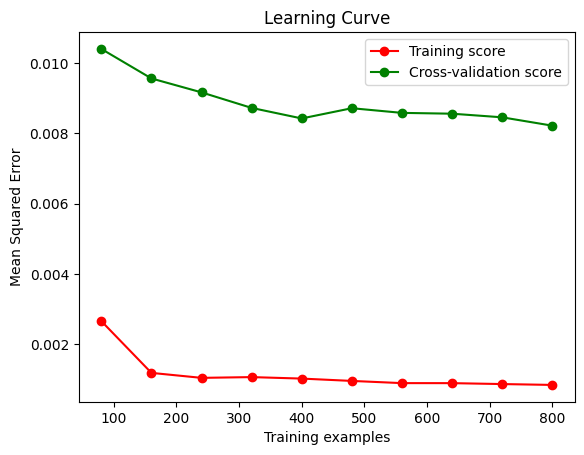

In [117]:
from sklearn.model_selection import learning_curve
import numpy as np


def plot_learning_curve(estimator, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring="neg_mean_squared_error",
    )

    train_scores_mean = -train_scores.mean(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)

    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Mean Squared Error")
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    plt.legend(loc="best")
    plt.show()


# Usage
model = xgb.XGBRegressor(
    random_state=42,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.05,
    min_child_weight=1,
    reg_alpha=0.5,
)
plot_learning_curve(model, X, y)

### Feature Construction and Evaluation

In [120]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression
import xgboost as xgb


def evaluate_feature_set(X, y, feature_names):
    model = xgb.XGBRegressor(random_state=42)
    scores = cross_val_score(model, X, y, cv=5, scoring="r2")
    return np.mean(scores)


def feature_importance(X, y):
    return mutual_info_regression(X, y)


def create_polynomial_features(X, degree=2):
    poly = PolynomialFeatures(degree, include_bias=False)
    return poly.fit_transform(X)


def evaluate_features(X, y, feature_names):
    base_score = evaluate_feature_set(X, y, feature_names)
    print(f"Base R^2 score: {base_score}")

    # Individual feature importance
    importances = feature_importance(X, y)
    for name, importance in zip(feature_names, importances):
        print(f"Feature {name} importance: {importance}")

    # Evaluate polynomial combinations
    X_poly = create_polynomial_features(X)
    poly_score = evaluate_feature_set(X_poly, y, feature_names)
    print(f"Polynomial features R^2 score: {poly_score}")

    # Evaluate custom combinations (example)
    X_custom = np.column_stack([X, X[:, 0] * X[:, 1], np.log1p(X[:, 2])])
    custom_names = feature_names + ["f1*f2", "log(f3)"]
    custom_score = evaluate_feature_set(X_custom, y, custom_names)
    print(f"Custom combinations R^2 score: {custom_score}")


feature_names = [
    f"x{i}" for i in range(X.shape[1])
]  # Replace with your actual feature names

evaluate_features(X, y, feature_names)

Base R^2 score: 0.1887734957966647
Feature x0 importance: 0.08140874646691909
Feature x1 importance: 0.13460521326409802
Feature x2 importance: 0.060840003794613295
Feature x3 importance: 0.0005065999144799882
Feature x4 importance: 0.04644524507989933
Feature x5 importance: 0.07490498610856955
Feature x6 importance: 0.06601646701949715
Feature x7 importance: 0.07298261643662407
Feature x8 importance: 0.04655309515130934
Feature x9 importance: 0.06597715294253659
Feature x10 importance: 0.11178924314551253
Feature x11 importance: 0.04599176660191917
Feature x12 importance: 0.0723895402753203
Feature x13 importance: 0.10822025405877334
Feature x14 importance: 0.0169114620847024
Feature x15 importance: 0.06341470387099601
Feature x16 importance: 0.11653544725706944
Feature x17 importance: 0.06312832198684415
Feature x18 importance: 0.024185931739609146
Feature x19 importance: 0.08356806072336909
Feature x20 importance: 0.07896804501496701
Feature x21 importance: 0.07962268500569758
Featu

### Feature Selection

In [92]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(estimator=xgb.XGBRegressor(), threshold="median")
X_selected = selector.fit_transform(X, y)
X_selected.shape

(800, 76)

### Training

In [118]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=325235
)

print(X_train.shape, X_test.shape)

(900, 41) (100, 41)


In [119]:
# Convert your data to GPU
X_train_gpu = cp.array(X_train)
y_train_gpu = cp.array(y_train)

In [124]:
reg_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.01,
    min_child_weight=3,
    # subsample=0.5,
    # colsample_bytree=0.8,
    reg_alpha=0.5,
    # reg_lambda=0.5,
    # gamma=0.1,
    random_state=3525,
    device="cuda",
)

In [125]:
reg_model.fit(X_train_gpu, y_train_gpu)

y_pred = reg_model.predict(X_train_gpu)
mse = mean_absolute_error(y_train, y_pred, multioutput="raw_values")[0]
r2 = r2_score(y_train, y_pred, multioutput="raw_values")[0]

print(f"Train MAE: {mse:.4f}")
print(f"Train R-squared: {r2:.4f}")

Train MAE: 0.0493
Train R-squared: 0.4554


In [122]:
# y_pred = [0.5] * len(y_test)
# mse = mean_absolute_error(y_test, y_pred, multioutput="raw_values")[0]
# r2 = r2_score(y_test, y_pred, multioutput="raw_values")[0]

# print(f"Baseline MAE: {mse:.4f}")
# print(f"Baseline R-squared: {r2:.4f}")

In [126]:
# X_test_selected = selector.transform(X_test)
X_test_gpu = cp.array(X_test)
y_pred = reg_model.predict(X_test_gpu)

mse = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

MAE: 0.0653
R-squared: 0.0135


: 

In [34]:
# plt.scatter(y_test, y_pred)

In [43]:
# Get feature importance
importance = reg_model.feature_importances_

fn_with_imp = sorted(list(zip(feature_names, importance)), key=lambda t: t[1])[::-1]

# Print feature importance
for fn, v in fn_with_imp[:10]:
    print(f"Feature {fn}: {v:.3f}")

# plt.bar([x for x in range(len(importance))], importance)
# plt.xlabel('Feature Index')
# plt.ylabel('Importance')
# plt.title('Feature Importance from XGBoost')
# plt.show()

Feature grad_max_top_1_bucket_2: 0.127
Feature grad_mean_top_3_bucket_1: 0.044
Feature crossover_point: 0.026
Feature grad_min_top_2_bucket_3: 0.025
Feature acc_min_top_2_bucket_2: 0.022
Feature acc_median_top_2_bucket_1: 0.021
Feature grad_median_top_1_bucket_1: 0.019
Feature grad_std_top_2_bucket_1: 0.019
Feature norm_std_bucket_1: 0.019
Feature acc_mean_top_3_bucket_2: 0.019
